## Question Answering with a fine-tuned BERT on CoQA dataset

### Importing the libraries

In [ ]:
!pip install transformers
!pip install torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

### Data loading

In [3]:
coqa = pd.read_json('http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json')
coqa.head()

version                                               data
0        1  {'source': 'wikipedia', 'id': '3zotghdk5ibi9ce...
1        1  {'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7...
2        1  {'source': 'gutenberg', 'id': '3bdcf01ogxu7zdn...
3        1  {'source': 'cnn', 'id': '3ewijtffvo7wwchw6rtya...
4        1  {'source': 'gutenberg', 'id': '3urfvvm165iantk...

### Data cleansing

In [8]:
del coqa["version"]

In [9]:
cols = ["text","question","answer"]

# j = 1
comp_list = []
for index, row in coqa.iterrows():
    for i in range(len(row["data"]["questions"])):
        temp_list = []
#         temp_list.append(j)
        temp_list.append(row["data"]["story"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        comp_list.append(temp_list)
#     j += 1
new_df = pd.DataFrame(comp_list, columns=cols) 

### Saving the data as csv

In [12]:
new_df.to_csv("CoQA_data.csv", index=False)

### Loading the data

In [4]:
data = pd.read_csv("CoQA_data.csv")
data.head()

text  \
0  The Vatican Apostolic Library (), more commonl...   
1  The Vatican Apostolic Library (), more commonl...   
2  The Vatican Apostolic Library (), more commonl...   
3  The Vatican Apostolic Library (), more commonl...   
4  The Vatican Apostolic Library (), more commonl...   

                            question                               answer  
0  When was the Vat formally opened?  It was formally established in 1475  
1           what is the library for?                             research  
2                 for what subjects?                     history, and law  
3                               and?     philosophy, science and theology  
4          what was started in 2014?                           a  project

In [5]:
data['text'][0]

'The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. \r\n\r\nThe Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. \r\n\r\nIn March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. \r\n\r\nThe Vatican Secret Archives were separated from the library at the be

In [6]:
data['question'][0]

'When was the Vat formally opened?'

In [14]:
print("Number of question and answers: ", len(data))

Number of question and answers:  108647


### Loading the pretrained models

In [7]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

### Exploring the tokens

In [16]:
random_num = np.random.randint(0,len(data))

question = data["question"][random_num]
text = data["text"][random_num]

In [17]:
print(question, "\n", text)

How many don't know where they're going? 
 Dhanusha, Nepal (CNN)At Kathmandu's Tribhuvan International Airport, hundreds of migrant workers line up daily at the immigration counters, clutching newly printed passports and boarding passes. Many of them, though, are clueless as to where they're headed. 

As a frequent traveler to the country, I've been approached many times by these men, asking me to help fill out their departure forms. 

Usually, when I ask what country they're traveling to, I get the same answer: "I'm not sure." 

They seem weary and lost but still hopeful that they can make their lives better. 

This time, however, I'm at the airport to follow up on the repatriation of the most unfortunate of these migrant workers -- far too many of them make the return journey in caskets. 

Almost every day, the remains of three or four workers arrive back in Nepal from the Middle East, according to Bhola Prasad Siwakoti, the secretary of the Nepalese Ministry of Labor and Manpower. E

In [18]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 382 tokens.


In [19]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):
    print('{:8}{:8,}'.format(token,id))

[CLS]        101
how        2,129
many       2,116
don        2,123
'          1,005
t          1,056
know       2,113
where      2,073
they       2,027
'          1,005
re         2,128
going      2,183
?          1,029
[SEP]        102
dh        28,144
##anus    20,849
##ha       3,270
,          1,010
nepal      8,222
(          1,006
cnn       13,229
)          1,007
at         2,012
kathmandu  28,045
'          1,005
s          1,055
tri       13,012
##bh      23,706
##u        2,226
##van      6,212
international   2,248
airport    3,199
,          1,010
hundreds   5,606
of         1,997
migrant   20,731
workers    3,667
line       2,240
up         2,039
daily      3,679
at         2,012
the        1,996
immigration   7,521
counters  24,094
,          1,010
clutching  14,197
newly      4,397
printed    6,267
passports  19,494
and        1,998
boarding   9,405
passes     5,235
.          1,012
many       2,116
of         1,997
them       2,068
,          1,010
though     2,295
,  

In [20]:
#first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print(sep_idx)

#number of tokens in segment A - question
num_seg_a = sep_idx+1
print(num_seg_a)

#number of tokens in segment B - text
num_seg_b = len(input_ids) - num_seg_a
print(num_seg_b)

segment_ids = [0]*num_seg_a + [1]*num_seg_b
print(segment_ids)

assert len(segment_ids) == len(input_ids)

13
14
368
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
#token input_ids to represent the input
#token segment_ids to differentiate our segments - text and question 
output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
#print(output.start_logits, output.end_logits)

In [15]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
#print(answer_start, answer_end)

In [16]:
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")
    
print("Text:\n{}".format(text.capitalize()))
print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))

Text:
(cnn) -- four days after suffering a humbling defeat to simona halep, serena williams turned the tables on the romanian to win a fifth wta finals title with a crushing straight sets 6-3 6-0 victory in singapore sunday. 

williams had called her 6-2 6-0 reverse in round-robin group play wednesday "embarrassing" and she set about putting the record straight in the title match. 

fourth-ranked halep began where she left off to take an early 2-1 lead with a break of service, but this was a very different williams on the other side of the net. 

the world number one immediately broke back and a further break to lead 5-3 was the start of eight games in a row without reply. 

a total of 26 winners flowed from the racket of the 33-year-old american veteran -- who was winning the end of season crown for the third straight year -- the first player since monica seles in 1992 to achieve the feat. 

"she was playing so well at the beginning and i told myself to just relax and once i did that 

### Visualization of the tokens

In [17]:
start_scores = output.start_logits.detach().numpy().flatten()
end_scores = output.end_logits.detach().numpy().flatten()

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

In [18]:
print(len(token_labels))

306


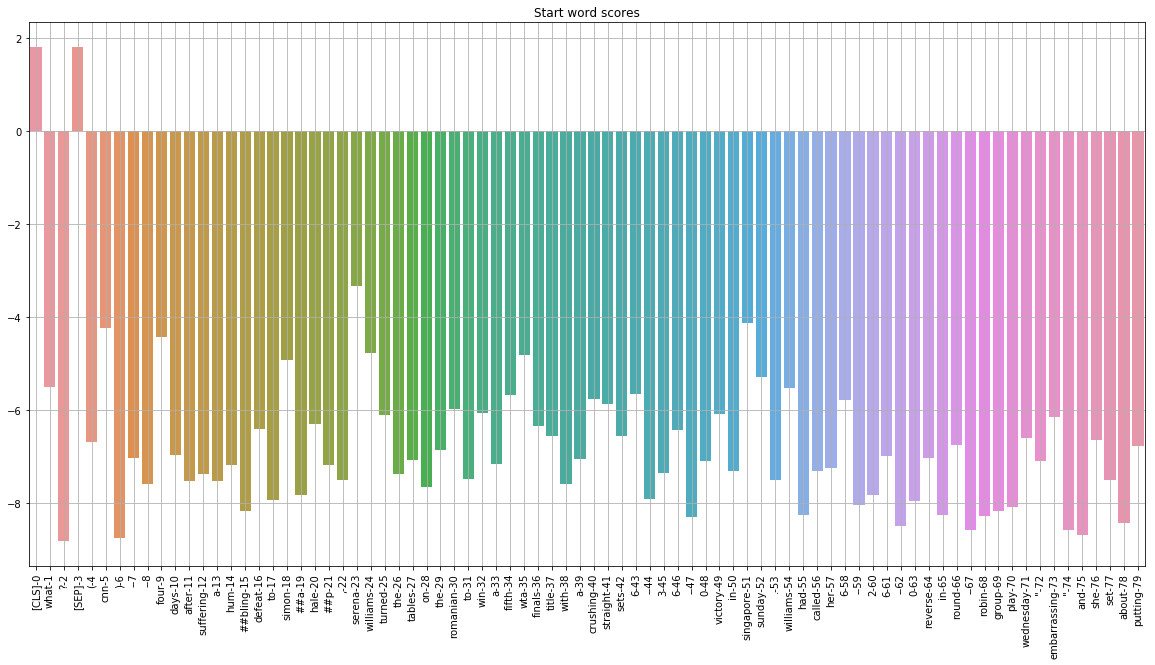

In [19]:
#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=start_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

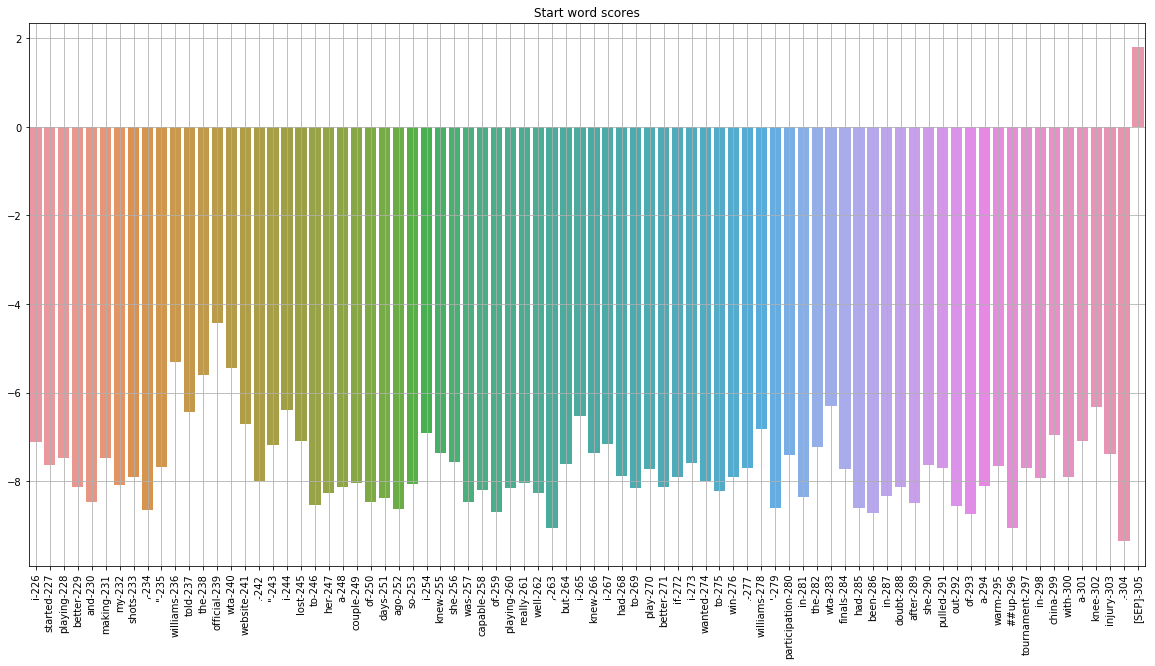

In [20]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=start_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

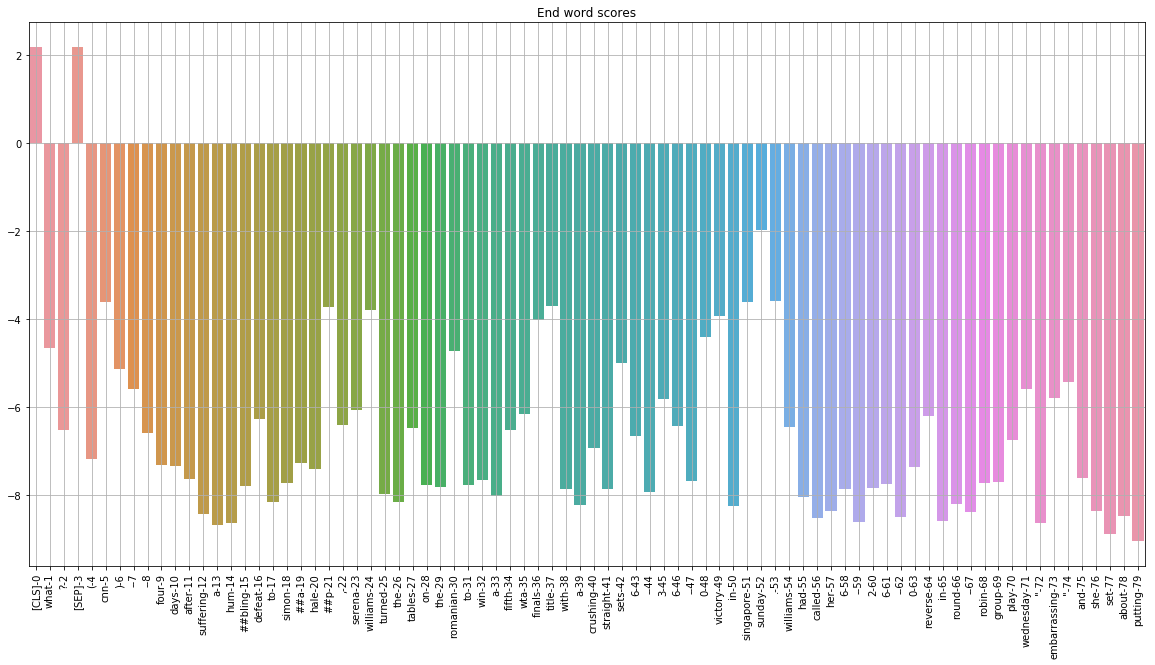

In [21]:
#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=end_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

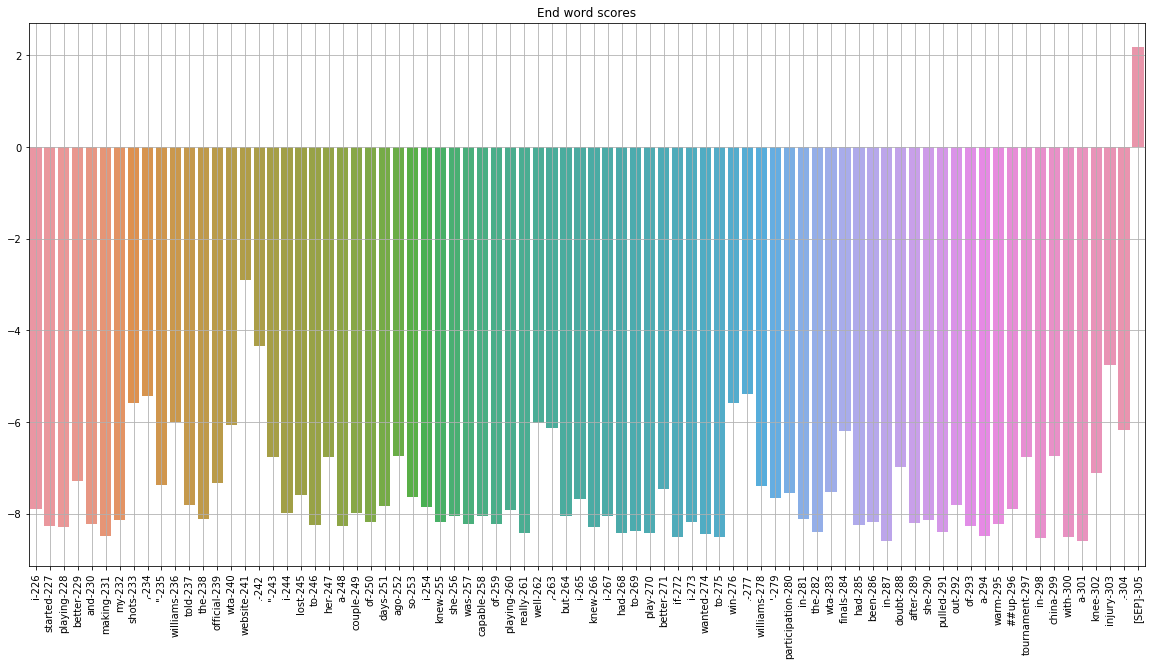

In [22]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=end_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

### Code to join the broken words

In [23]:
answer = tokens[answer_start]

for i in range(answer_start+1, answer_end+1):
    if tokens[i][0:2] == "##":
        answer += tokens[i][2:]
    else:
        answer += " " + tokens[i]

### Function

In [9]:
def question_answer(question, text):
    
    #tokenize question and text in ids as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    #number of tokens in segment A - question
    num_seg_a = sep_idx+1

    #number of tokens in segment B - text
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    
#     print("Text:\n{}".format(text.capitalize()))
#     print("\nQuestion:\n{}".format(question.capitalize()))
    print("\nAnswer:\n{}".format(answer.capitalize()))

In [19]:
text = """The game was over. Rafael Nadal had made it to the French Open Final for a record 14th time. But there were no celebrations. Not because this was Nadal winning Tennis on clay. All the eyes, including those of the 21 time grand slam winner were on Alexander Zverev.

After more than three hours of play, the 25-year old was forced to leave the court in tears on a wheelchair after turning his ankle.

The 2020 US Open Singles runner-up was trailing 7-6 (10/8), 6-6 when horror took over Philippe Chatrier court in Stade Roland Garros. The fall was so bad that the broadcasters decided on not running replays of the same. 

As shared by one of the spectators present at the venue on his Twitter account, when the replay was played on the giant screen there was a joint look of horror on everyone’s face."""

question = "What is the name of the court of the 2020 match?"

question_answer(question, text)


Answer:
Philippe chatrier court in stade roland garros


In [23]:
print("Original answer:\n", data.loc[data["question"] == question]["answer"].values[0])

Original answer:
 Hard Rock Cafe


### Playing with the chatbot

In [20]:
text = input("Please enter your text: \n")
question = input("\nPlease enter your question: \n")

while True:
    question_answer(question, text)
    
    flag = True
    flag_N = False
    
    while flag:
        response = input("\nDo you want to ask another question based on this text (Y/N)? ")
        if response[0] == "Y":
            question = input("\nPlease enter your question: \n")
            flag = False
        elif response[0] == "N":
            print("\nBye!")
            flag = False
            flag_N = True
            
    if flag_N == True:
        break


Answer:
Philippe chatrier court in stade roland garros

Bye!
